## Data Cleanup, Analisys, and Preparation for Machine Learning



In [1]:
# Imports
import pandas as pd
import numpy as np
from __future__ import print_function

%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Read in raw data
schoolData = pd.read_csv('D:/BenepactLLC/Belk/NC_Report_Card_Data/Summary Data Files/All_Data_By_School_Final.csv'
                         , low_memory=False)
testScores = pd.read_csv('D:/BenepactLLC/Belk/NC_Report_Card_Data/Summary Data Files/1516_Test_Scores.csv', low_memory=False)

#Review raw data before the join
schoolData.info()

#join files using school / unit code
schoolData = schoolData.merge(testScores, on='unit_code', how='left', suffixes=('_schoolData', '_testScores'))

#Review raw data after the join to make sure new fields were added
print('************************************************************')
schoolData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Columns: 293 entries, Year to State_Prin_Exp_Pct_10+_Years
dtypes: float64(255), int64(17), object(21)
memory usage: 5.8+ MB
************************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Columns: 365 entries, Year to Passing_Math_III
dtypes: float64(324), int64(17), object(24)
memory usage: 7.2+ MB


In [2]:
#Remove fields not needed for machine learning
excludeFields = ['Year','unit_code_schoolData', 'street_ad','scity_ad','state_ad','szip_ad','Closed_Ind_Text','New_ind_Txt',
                 'grades_BYOD','grades_1_to_1_access','District Name','unit_code_testScores','School Name','SBE District']

keepFields = [col for col in schoolData.columns if col not in excludeFields]

schoolData = schoolData[keepFields]

schoolData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Columns: 353 entries, unit_code to Passing_Math_III
dtypes: float64(324), int64(15), object(14)
memory usage: 7.0+ MB


In [3]:
#Clean up the dataset for machine learning 
boolFields = ['title1_type_flg', 'clp_ind_flg', 'focus_clp_flg', 'summer_program_flg', 
              'asm_no_spg_flg', 'no_data_spg_flg', 'stem_flg']

# Map flag fields into bool 
schoolData['title1_type_flg'] = schoolData['title1_type_flg'].map({-1:True, 0:False})
schoolData['clp_ind_flg'] = schoolData['clp_ind_flg'].map({-1:True, 0:False})
schoolData['focus_clp_flg'] = schoolData['focus_clp_flg'].map({-1:True, 0:False})
schoolData['summer_program_flg'] = schoolData['summer_program_flg'].map({-1:True, 0:False})
schoolData['asm_no_spg_flg'] = schoolData['asm_no_spg_flg'].map({-1:True, 0:False})
schoolData['no_data_spg_flg'] = schoolData['no_data_spg_flg'].map({-1:True, 0:False})
schoolData['stem_flg'] = schoolData['stem_flg'].map({-1:True, 0:False})

#
schoolData['esea_status'] = schoolData['esea_status'].map({'P':'Esea_Pass', 'F':'Esea_Fail', np.nan:'Non_Esea'})
schoolData['Grad_project_status'] = schoolData['Grad_project_status'].map({'Y':True, 'N':False, np.nan:False})

In [4]:
# Find all the categorical variables
schoolData_Bool = schoolData.loc[:, schoolData.dtypes == bool]
schoolData_Vars = schoolData.loc[:, schoolData.dtypes == object]
cat_list_obj = list(pd.concat([schoolData_Vars, schoolData_Bool]))
cat_list_obj_len = len(cat_list_obj) # number of object attributes
print("Number of Categorical Attributes = ", cat_list_obj_len)
cat_list_obj

Number of Categorical Attributes =  21


['1_to_1_access',
 'Byod',
 'EVAAS Growth Status',
 'Grad_project_status',
 'Math SPG Grade',
 'Reading SPG Grade',
 'SPG Grade',
 'State Gap Compared',
 'asm_no_spg_flg',
 'calendar_only_txt',
 'category_cd',
 'clp_ind_flg',
 'esea_status',
 'focus_clp_flg',
 'no_data_spg_flg',
 'school_type_txt',
 'stem_flg',
 'summer_program_flg',
 'title1_type_flg',
 'type_cd_txt',
 'unit_code']

In [5]:
#Review individual data types after data preparation
schoolData.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 0 to 2578
Data columns (total 353 columns):
unit_code                                         object
type_cd_txt                                       object
category_cd                                       object
school_type_txt                                   object
calendar_only_txt                                 object
title1_type_flg                                   bool
clp_ind_flg                                       bool
focus_clp_flg                                     bool
summer_program_flg                                bool
asm_no_spg_flg                                    bool
no_data_spg_flg                                   bool
esea_status                                       object
student_num                                       float64
lea_avg_student_num                               float64
st_avg_student_num                                int64
Grad_project_status                             

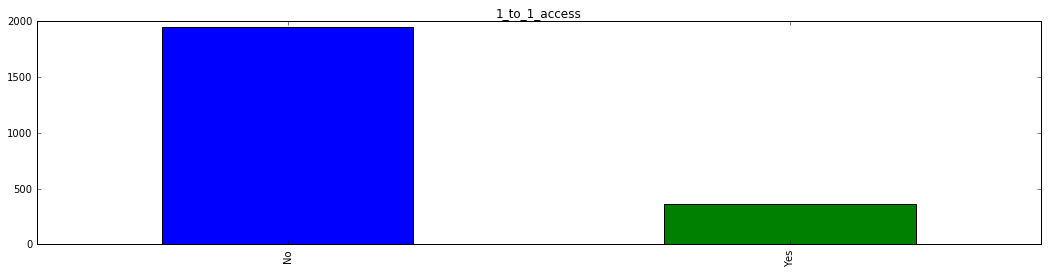

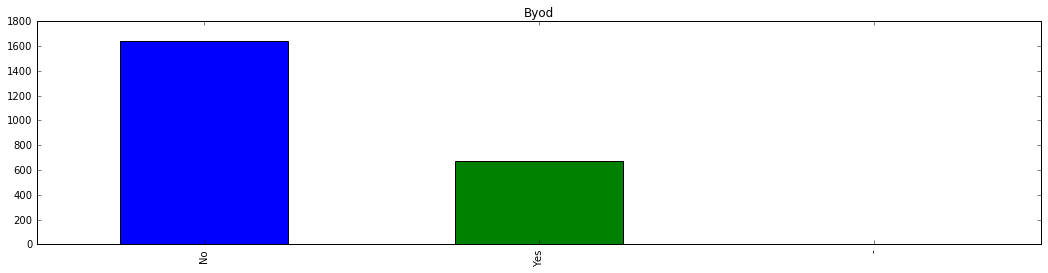

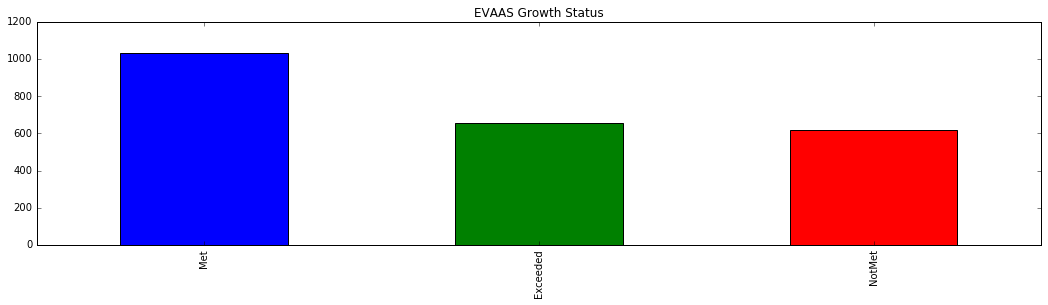

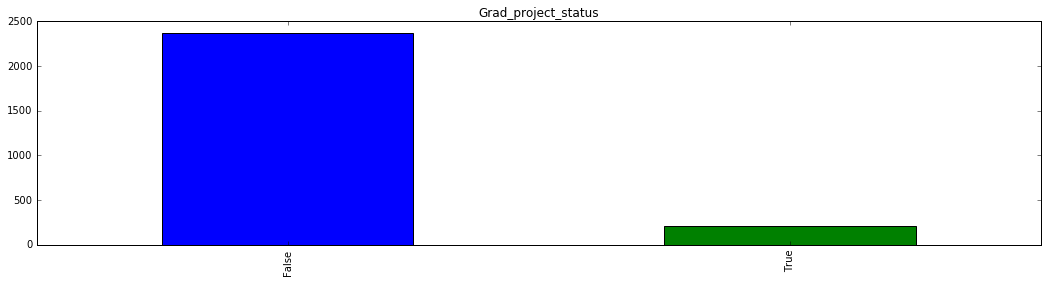

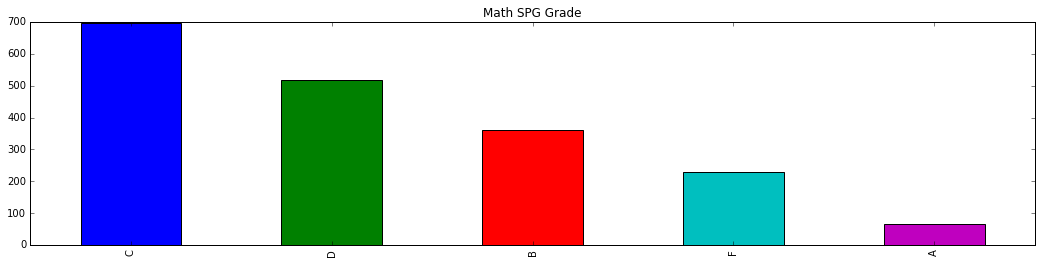

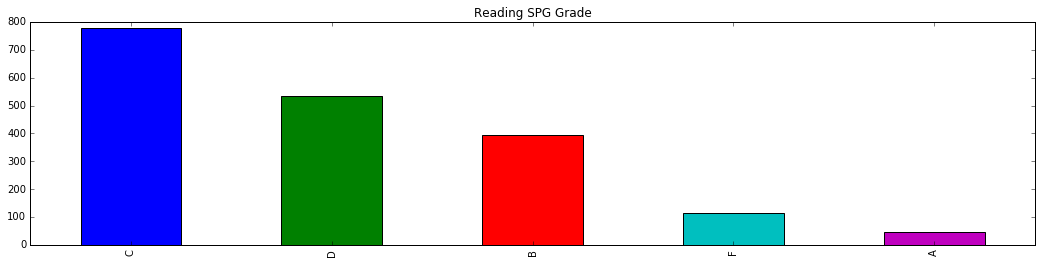

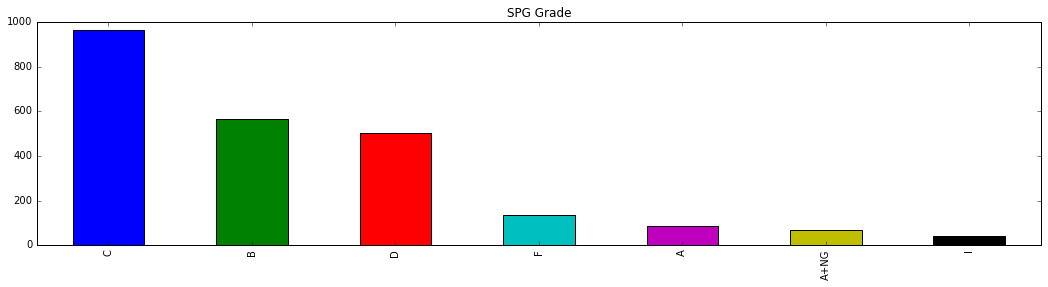

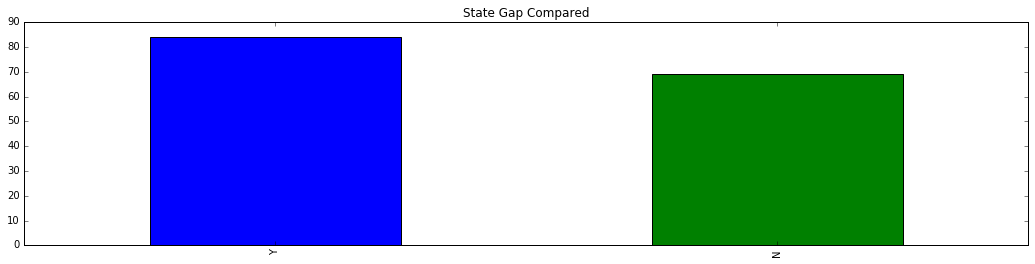

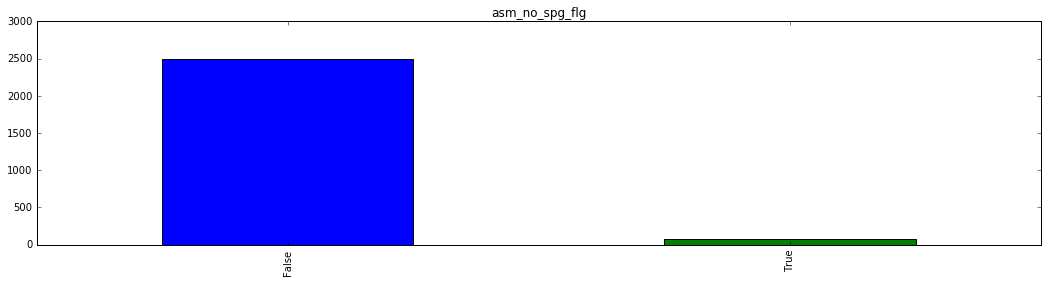

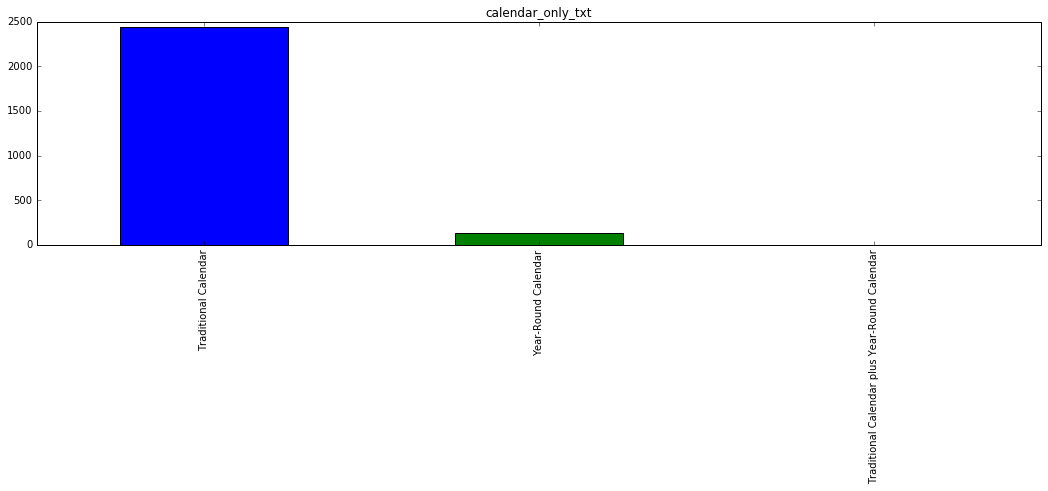

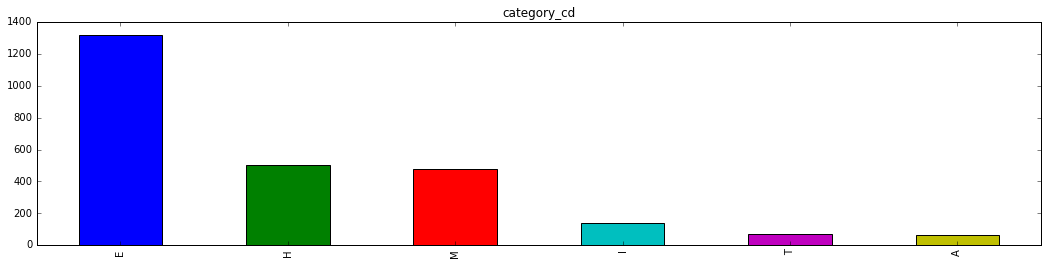

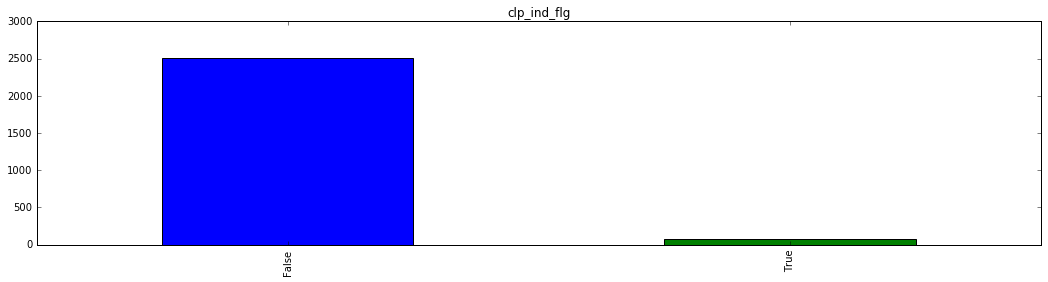

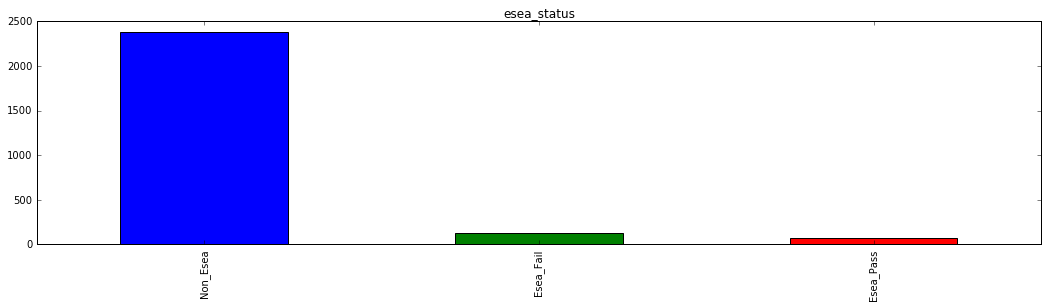

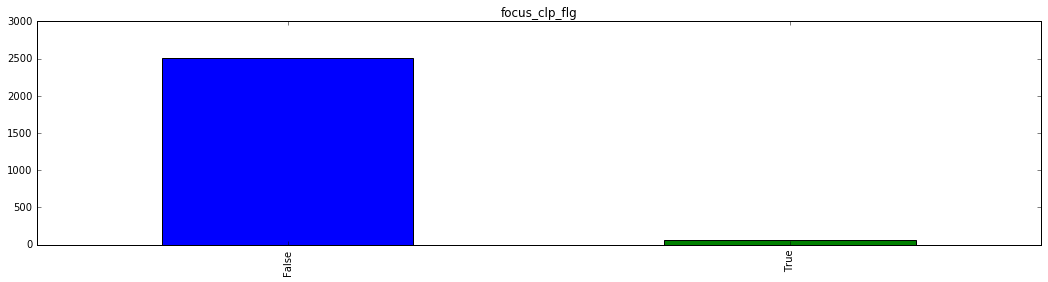

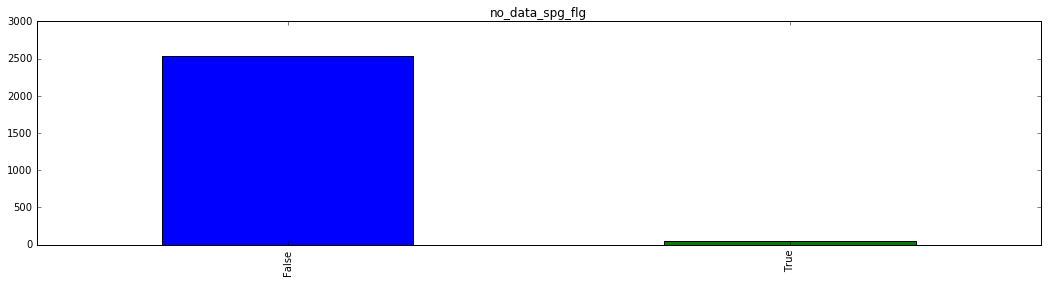

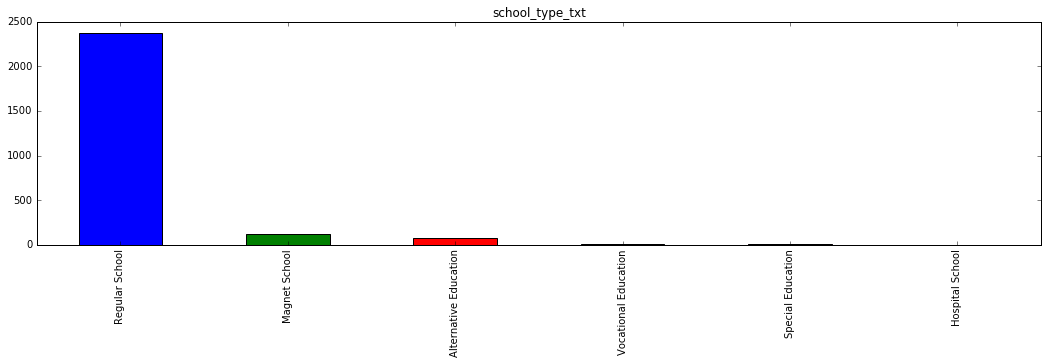

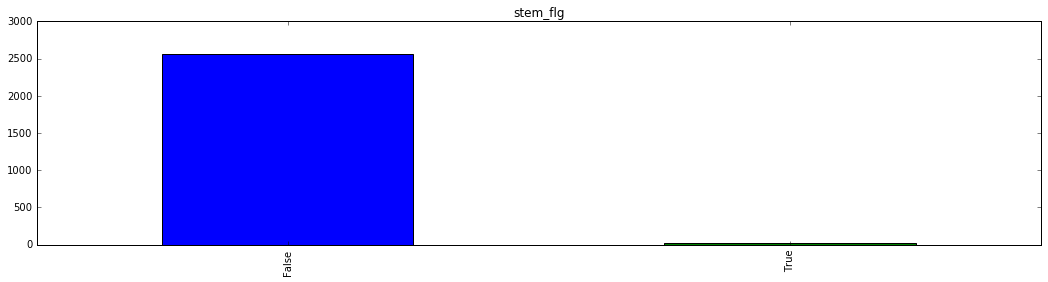

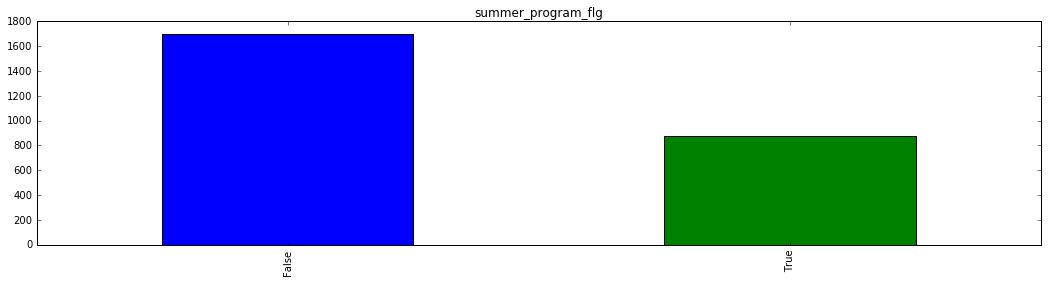

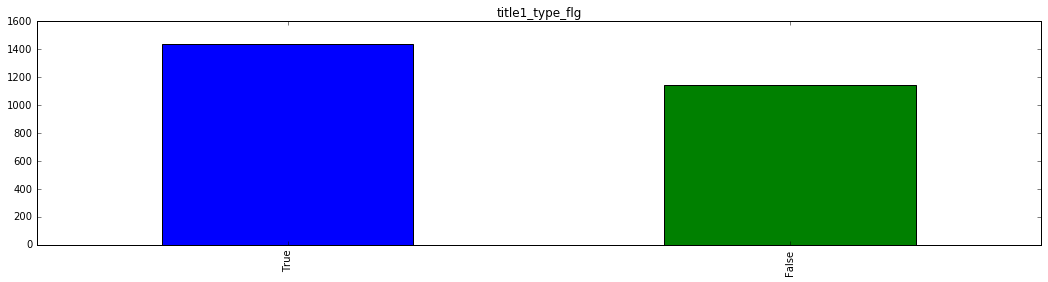

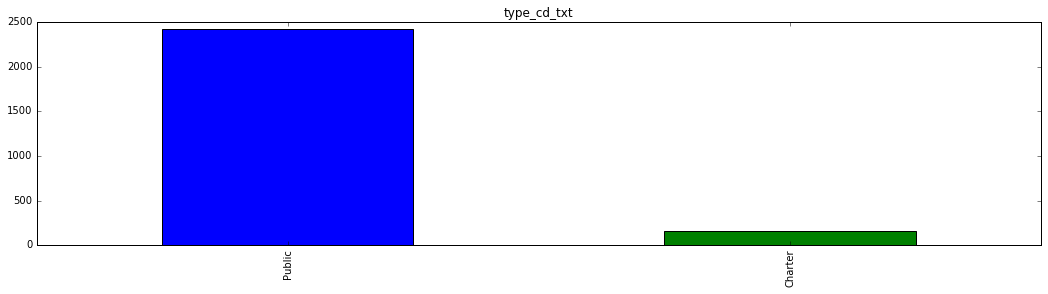

In [6]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt

for i in range(0,cat_list_obj_len-1):
    plt.figure(figsize = (18,4))
    ax = schoolData[cat_list_obj[i]].value_counts().plot(kind='bar')
    plt.title(cat_list_obj[i])
    plt.show()

In [7]:
highSchools = schoolData [((schoolData.category_cd == 'H') | 
                          (schoolData.category_cd == 'T') | 
                          (schoolData.category_cd == 'A'))&
                          (schoolData.Graduation_Rate4_Yr > 0) &
                          (schoolData.student_num > 0) & 
                          (schoolData.type_cd_txt == 'Public') & 
                          (schoolData.school_type_txt == 'Regular School')
                         ]

highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 116 to 2419
Columns: 353 entries, unit_code to Passing_Math_III
dtypes: bool(8), float64(324), int64(8), object(13)
memory usage: 1.2+ MB


In [8]:
#Inspect the high school data fields 
df_temp = highSchools.describe(include='all').T
# include the data type of the column in the dataframe
df_temp['type']= highSchools.dtypes
# Reset the index of the dataframe to have index as numbers to have the number of rows visible in the output
df_temp.reset_index(inplace=True)
df_temp

,index,count,unique,top,freq,mean,std,min,25%,50%,75%,max,type
0,unit_code,440,440,700319,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
1,type_cd_txt,440,1,Public,440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
2,category_cd,440,3,H,425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
3,school_type_txt,440,1,Regular School,440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
4,calendar_only_txt,440,2,Traditional Calendar,433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
5,title1_type_flg,440,2,False,407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bool
6,clp_ind_flg,440,2,False,385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bool
7,focus_clp_flg,440,2,False,390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bool
8,summer_program_flg,440,2,False,276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bool
9,asm_no_spg_flg,440,1,False,440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bool


In [9]:
#List of all int32 fields
int32Fields = ['student_num', 'lea_avg_student_num','Avg_Class_Size_00','Avg_Class_Size_01',
             'Avg_Class_Size_02','Avg_Class_Size_03','Avg_Class_Size_04','Avg_Class_Size_05',
             'Avg_Class_Size_06','Avg_Class_Size_07','Avg_Class_Size_08','Avg_Class_Size_Biology',
             'Avg_Class_Size_EnglishII','Avg_Class_Size_MathI','Avg_Dist_Size_00','Avg_Dist_Size_01',
             'Avg_Dist_Size_02','Avg_Dist_Size_03','Avg_Dist_Size_04','Avg_Dist_Size_05','Avg_Dist_Size_06',
             'Avg_Dist_Size_07','Avg_Dist_Size_08','Avg_Dist_Size_Biology','Avg_Dist_Size_EnglishII',
             'Avg_State_Size_04','Avg_State_Size_05','Avg_State_Size_06','Avg_State_Size_07','Avg_State_Size_08',
             'Avg_State_Size_Biology','Avg_State_Size_EnglishII','Avg_State_Size_MathI','SPG Score','Reading  SPG Score',
             'Math SPG Score','Overall Achievement Score','Read Score','Math Score','Science Score','Math I Score',
             'English II Score','Biology Score','The ACT Score','ACT WorkKeys Score','Math Course Rigor Score',
             'Cohort Graduation Rate Standard Score','sat_avg_score_num','lea_sat_avg_score_num','st_sat_avg_score_num',
             'nat_sat_avg_score_num','avg_age_media_collection','lea_avg_age_media_collection','st_avg_age_media_collection',
             'wap_num','lea_wap_num','st_wap_num','class_teach_num','nbpts_num','lea_class_teach_num','lea_nbpts_num',
             'st_class_teach_num','st_nbpts_num']

#Cannot convert from float64 to int32 due to missing values, should revisit this 
#highSchools[int32Fields] = highSchools[int32Fields].apply(np.int32, axis=1)

In [10]:
#Look at missing / NaN values by column
for col in highSchools:
    x = highSchools[col].value_counts(dropna=False)
    print(x)
    print('***************************************************')

700319    1
130333    1
500302    1
110352    1
490310    1
350308    1
860336    1
980336    1
422315    1
960700    1
422310    1
182700    1
130332    1
510324    1
740344    1
510327    1
570317    1
100334    1
410595    1
190342    1
760388    1
570318    1
600426    1
200350    1
940316    1
730352    1
410508    1
210312    1
670340    1
630332    1
         ..
350317    1
800396    1
900311    1
100307    1
640350    1
410408    1
780342    1
960330    1
360337    1
360336    1
180308    1
132304    1
240334    1
410355    1
510357    1
340382    1
410358    1
490320    1
340454    1
761304    1
920588    1
900377    1
410562    1
920582    1
292324    1
920581    1
410569    1
260411    1
180376    1
920473    1
Name: unit_code, Length: 440, dtype: int64
***************************************************
Public    440
Name: type_cd_txt, dtype: int64
***************************************************
H    425
T     12
A      3
Name: category_cd, dtype: int64
****************

In [11]:
#High school - excluded fields and reasons
excludeFeaturesHS = ['no_data_spg_flg', #all false or NaN
 'Avg_Class_Size_00', #NA for High Schools
 'Avg_Class_Size_01', #NA for High Schools
 'Avg_Class_Size_02', #NA for High Schools
 'Avg_Class_Size_03', #NA for High Schools
 'Avg_Class_Size_04', #NA for High Schools
 'Avg_Class_Size_05', #NA for High Schools
 'Avg_Class_Size_06', #NA for High Schools
 'Avg_Class_Size_07', #NA for High Schools
 'Avg_Class_Size_08', #NA for High Schools
 'Avg_Dist_Size_00', #NA for High Schools
 'Avg_Dist_Size_01', #NA for High Schools
 'Avg_Dist_Size_02', #NA for High Schools
 'Avg_Dist_Size_03', #NA for High Schools
 'Avg_Dist_Size_04', #NA for High Schools
 'Avg_Dist_Size_05', #NA for High Schools
 'Avg_Dist_Size_06', #NA for High Schools
 'Avg_Dist_Size_07', #NA for High Schools
 'Avg_Dist_Size_08', #NA for High Schools
 'Avg_State_Size_00', #NA for High Schools
 'Avg_State_Size_01', #NA for High Schools
 'Avg_State_Size_02', #NA for High Schools
 'Avg_State_Size_03', #NA for High Schools
 'Avg_State_Size_04', #NA for High Schools
 'Avg_State_Size_05', #NA for High Schools
 'Avg_State_Size_06', #NA for High Schools
 'Avg_State_Size_07', #NA for High Schools
 'Avg_State_Size_08', #NA for High Schools
 'total_expense_num', #494 NaN
 'salary_expense_pct', #494 NaN
 'services_expense_pct', #494 NaN
 'supplies_expense_pct', #494 NaN
 'instruct_equip_exp_pct', #494 NaN
 'other_expense_pct', #494 NaN
 'federal_perpupil_num', #494 NaN
 'local_perpupil_num', #494 NaN
 'state_perpupil_num', #494 NaN
 'lea_other_expense_pct', #All 0 or NaN
 'st_total_expense_num', #Same Value
 'st_salary_expense_pct', #Same Value
 'st_benefits_expense_pct', #Same Value
 'st_services_expense_pct', #Same Value
 'st_supplies_expense_pct', #Same Value
 'st_instruct_equip_exp_pct', #Same Value
 'st_other_expense_pct', #Same Value
 'st_federal_perpupil_num', #Same Value
 'st_local_perpupil_num', #Same Value
 'st_state_perpupil_num', #Same Value
 'Reading SPG Grade', #NA for High Schools
 'Reading  SPG Score', #NA for High Schools
 'Math SPG Grade', #NA for High Schools
 'Math SPG Score', #NA for High Schools
 'Read Score', #NA for High Schools
 'Math Score', #NA for High Schools
 'Science Score', #NA for High Schools
 'ACT WorkKeys Score', #81 NaN
 'GCE_LEP_School_Pct', #440 NaN
 'GCE_PRM_School_Pct', #440 NaN
 'GCE_RPF_School_Pct', #440 NaN
 'GCE_SWD_School_Pct', #440 NaN
 'PASSED_EOG_School_Pct', #438 NaN
 'PASSED_LAA_School_Pct', #440 NaN
 'PASSED_RTA_School_Pct', #440 NaN
 'PROMOTED_School_Pct', #438 NaN
 'RETAINED_School_Pct', #440 NaN
 'GCE_ALL_Dist_Pct', #437 NaN
 'GCE_LEP_Dist_Pct', #440 NaN
 'GCE_PRM_Dist_Pct', #440 NaN
 'GCE_RPF_Dist_Pct', #439 NaN
 'GCE_SWD_Dist_Pct', #438 NaN
 'PASSED_EOG_Dist_Pct', #437 NaN
 'PASSED_LAA_Dist_Pct', #438 NaN
 'PASSED_RTA_Dist_Pct', #440 NaN
 'PROMOTED_Dist_Pct', #437 NaN
 'RETAINED_Dist_Pct', #438 NaN
 'GCE_ALL_State_Pct', #437 NaN
 'GCE_LEP_State_Pct', #440 NaN
 'GCE_PRM_State_Pct', #440 NaN
 'GCE_RPF_State_Pct', #440 NaN
 'GCE_SWD_State_Pct', #437 NaN
 'PASSED_EOG_State_Pct', #437 NaN
 'PASSED_LAA_State_Pct', #437 NaN
 'PASSED_RTA_State_Pct', #440 NaN
 'PROMOTED_State_Pct', #437 NaN
 'RETAINED_State_Pct', #437 NaN
 'st_sat_avg_score_num  ', #All Same Value 
 'nat_sat_avg_score_num', #All Same Value
 'st_sat_participation_pct', #All Same Value 
 'nat_sat_participation_pct', #All Same Value
 'esea_attendance', #440 NaN
 'lea_esea_attendance', #440 NaN
 'st_ap_participation_pct', #All Same Value
 'st_ap_pct_3_or_above', #All Same Value
 'ib_participation_pct', #434 NaN
 'lea_ib_participation_pct', #440 NaN
 'st_ib_participation_pct', #440 NaN
 'ib_pct_4_or_above', #416 NaN
 'lea_ib_pct_4_or_above', #261 NaN
 'st_ib_pct_4_or_above', #All Same Value
 'st_total_specialized_courses', #All Same Value
 'st_ap_ib_courses ', #All Same Value
 'st_cte_courses', #All Same Value
 'st_univ_college_courses', #All Same Value
 'ttl_crimes_num', #440 NaN
 'st_expelled_per_c_num', #All Same Value
 'st_avg_age_media_collection ', #All Same Value
 'st_books_per_student', #All Same Value
 'st_wap_num', #All Same Value
 'st_wap_per_classroom', #All Same Value
 'prin_other_pct', #440 NaN
 'prinyrs_0thru3_pct', #440 NaN
 'prinyrs_4thru10_pct', #440 NaN
 'prinyrs_11plus_pct', #440 NaN
 'prin_advance_dgr_pct', #440 NaN
 '_1yr_prin_trnovr_pct', #440 NaN
 'prin_male_pct', #440 NaN
 'prin_female_pct', #440 NaN
 'prin_black_pct', #440 NaN
 'prin_white_pct', #440 NaN
 'emer_prov_teach_pct    ', #385 NaN 
 'st_highqual_class_hp_pct ', #All Same Value
 'st_highqual_class_lp_pct ', #All Same Value
 'st_highqual_class_all_pct ', #All Same Value
 'st_not_highqual_class_hp_pct ', #All Same Value
 'st_not_highqual_class_lp_pct ', #All Same Value
 'st_not_highqual_class_all_pct ', #All Same Value
 'st_prinyrs_0thru3_pct ', #All Same Value
 'st_prinyrs_4thru10_pct ', #All Same Value
 'st_prinyrs_11plus_pct', #All Same Value
 'st_prin_advance_dgr_pct', #All Same Value
 'st_1yr_prin_trnovr_pct ', #All Same Value
 'st_prin_male_pct ', #All Same Value
 'st_prin_female_pct ', #All Same Value
 'st_prin_black_pct ', #All Same Value
 'st_prin_white_pct', #All Same Value
 'st_prin_other_pct', #All Same Value
 'State_Prin_Exp_Pct_0_3_Years ', #All Same Value
 'State_Prin_Exp_Pct_4_10_Years ', #All Same Value
 'State_Prin_Exp_Pct_10+_Years ', #All Same Value
 'All_EOG_Subjects_CACR', #428 NaN 
 'All_EOG_Subjects_GLP', #428 NaN 
 'EOG_Gr3_CACR', #NA for High Schools
 'EOG_Gr3_GLP', #NA for High Schools
 'EOG_Gr4_CACR', #NA for High Schools
 'EOG_Gr4_GLP', #NA for High Schools
 'EOG_Gr5_CACR', #NA for High Schools
 'EOG_Gr5_GLP', #NA for High Schools
 'EOG_Gr6_CACR', #NA for High Schools
 'EOG_Gr6_GLP', #NA for High Schools
 'EOG_Gr7_CACR', #NA for High Schools
 'EOG_Gr7_GLP', #NA for High Schools
 'EOG_Gr8_CACR', #NA for High Schools
 'EOG_Gr8_GLP', #NA for High Schools
 'EOG_Math_Gr3_CACR', #NA for High Schools
 'EOG_Math_Gr3_GLP', #NA for High Schools
 'EOG_Math_Gr3-8_CACR', #NA for High Schools
 'EOG_Math_Gr3-8_GLP', #NA for High Schools
 'EOG_Math_Gr4_CACR', #NA for High Schools
 'EOG_Math_Gr4_GLP', #NA for High Schools
 'EOG_Math_Gr5_CACR', #NA for High Schools
 'EOG_Math_Gr5_GLP', #NA for High Schools
 'EOG_Math_Gr6_CACR', #NA for High Schools
 'EOG_Math_Gr6_GLP', #NA for High Schools
 'EOG_Math_Gr7_CACR', #NA for High Schools
 'EOG_Math_Gr7_GLP', #NA for High Schools
 'EOG_Math_Gr8_CACR', #NA for High Schools
 'EOG_Math_Gr8_GLP', #NA for High Schools
 'EOG_Reading_G3_GLP', #NA for High Schools
 'EOG_Reading_Gr3_CACR', #NA for High Schools
 'EOG_Reading_Gr4_CACR', #NA for High Schools
 'EOG_Reading_Gr4_GLP', #NA for High Schools
 'EOG_Reading_Gr5_CACR', #NA for High Schools
 'EOG_Reading_Gr5_GLP', #NA for High Schools
 'EOG_Reading_Gr6_CACR', #NA for High Schools
 'EOG_Reading_Gr6_GLP', #NA for High Schools
 'EOG_Reading_Gr7_CACR', #NA for High Schools
 'EOG_Reading_Gr7_GLP', #NA for High Schools
 'EOG_Reading_Gr8_CACR', #NA for High Schools
 'EOG_Reading_Gr8_GLP', #NA for High Schools
 'EOG_Reading_Grades_3_8_CACR', #NA for High Schools
 'EOG_Reading_Grades_3_8_GLP', #NA for High Schools
 'EOG_Science_Gr5_CACR', #NA for High Schools
 'EOG_Science_Gr5_GLP', #NA for High Schools
 'EOG_Science_Gr8_CACR', #NA for High Schools
 'EOG_Science_Gr8_GLP', #NA for High Schools
 'EOG_Science_Grades_5&8_CACR', #NA for High Schools
 'EOG_Science_Grades_5&8_GLP', #NA for High Schools
 'Graduation_Rate_5_Yr', #Using 4 year graduation rate as response variable
 'type_cd_txt', #Only 'Public' after filter
 'school_type_txt', #Only 'Regular School' after filter 
 'asm_no_spg_flg', #All False after filters
 'benefits_expense_pct', #440 NaN
 'State Gap Compared', #360 NaN
 'GCE_ALL_School_Pct', #437
 'emer_prov_teach_pct', #385 NaN
 'lea_emer_prov_teach_pct', #226 NaN 
 'Avg_State_Size_Biology', #All same value
 'Avg_State_Size_EnglishII', #All same value
 'Avg_State_Size_MathI', #All same value
 'st_sat_avg_score_num', #All same value 
 'st_ap_ib_courses', #All same value
 'st_avg_daily_attend_pct', #All same value
 'st_crime_per_c_num', #All same value
 'st_short_susp_per_c_num', #All same value
 'st_long_susp_per_c_num', #All same value
 'st_stud_internet_comp_num', #All same value
 'st_avg_age_media_collection', #All same value
 'st_flicensed_teach_pct', #All same value
 #'st_tchyrs_0thru3_pct', #All same value
 #'st_tchyrs_4thru10_pct', #All same value
 #'st_tchyrs_11plus_pct', #All same value
 'st_class_teach_num', #All same value
 'st_nbpts_num', #All same value
 'st_advance_dgr_pct', #All same value
 'st_1yr_tchr_trnovr_pct', #All same value
 'st_emer_prov_teach_pct', #All same value
 'st_lateral_teach_pct', #All same value
 'st_highqual_class_pct', #All same value
 'st_highqual_class_hp_pct', #All same value
 'st_highqual_class_lp_pct', #All same value
 'st_highqual_class_all_pct', #All same value
 'st_not_highqual_class_hp_pct', #All same value
 'st_not_highqual_class_lp_pct', #All same value
 'st_not_highqual_class_all_pct', #All same value
 'st_prinyrs_0thru3_pct', #All same value
 'st_prinyrs_4thru10_pct', #All same value
 'st_1yr_prin_trnovr_pct', #All same value
 'st_prin_male_pct', #All same value
 'st_prin_female_pct', #All same value
 'st_prin_black_pct', #All same value
 'State_Tch_Exp_Pct_0_3_Years', #All same value
 'State_Tch_Exp_Pct_4_10_Years', #All same value
 'State_Tch_Exp_Pct_10+_Years', #All same value
 'State_Prin_Exp_Pct_0_3_Years', #All same value
 'State_Prin_Exp_Pct_4_10_Years', #All same value
 'State_Prin_Exp_Pct_10+_Years', #All same value
 'st_avg_student_num', #All same value 
 'unit_code', #School primary key, different for all records
 #-----------------------Added 01/30/2018------------------------
 #Removes dup fields to avoid Multicollinearity
 'tchyrs_0thru3_pct', #Duplicate field -> Tch_Exp_Pct_0_3_Years
 'tchyrs_4thru10_pct', #Duplicate field -> Tch_Exp_Pct_4_10_Years
 'tchyrs_11plus_pct', #Duplicate field -> Tch_Exp_Pct_10+_Years
 'lea_tchyrs_0thru3_pct', #Duplicate field -> Dist_Tch_Exp_Pct_0_3_Years
 'lea_tchyrs_4thru10_pct', #Duplicate field -> Dist_Tch_Exp_Pct_4_10_Years
 'lea_tchyrs_11plus_pct', #Duplicate field -> Dist_Tch_Exp_Pct_10+_Years
 'st_tchyrs_0thru3_pct', #Duplicate field -> State_Tch_Exp_Pct_0_3_Years
 'st_tchyrs_4thru10_pct', #Duplicate field -> State_Tch_Exp_Pct_4_10_Years
 'st_tchyrs_11plus_pct', #Duplicate field -> State_Tch_Exp_Pct_10+_Years
                    ]

keepFields = [col for col in highSchools.columns if col not in excludeFeaturesHS]

highSchools = highSchools[keepFields]

highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 116 to 2419
Columns: 128 entries, category_cd to Passing_Math_III
dtypes: bool(6), float64(115), object(7)
memory usage: 425.4+ KB


In [12]:
#Re-examine missing / NaN values by column
#for col in highSchools:
#    x = highSchools[col].value_counts(dropna=False)
#    print(x)
#    print('***************************************************')

In [13]:
#Review Missing values 
missing_values = highSchools.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 

#Print all rows with missing values
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(missing_values)

                                      Variable Name  Number Missing Values
11                           Avg_Class_Size_Biology                      9
12                         Avg_Class_Size_EnglishII                      8
13                             Avg_Class_Size_MathI                     12
14                            Avg_Dist_Size_Biology                      7
15                          Avg_Dist_Size_EnglishII                      7
16                              Avg_Dist_Size_MathI                      7
26                                        SPG Grade                      1
27                                        SPG Score                      1
28                              EVAAS Growth Status                      8
29                               EVAAS Growth Score                      8
30                        Overall Achievement Score                      1
31                                     Math I Score                      9
32                       

In [14]:
# Find all the high school categorical variables
schoolData_Bool = highSchools.loc[:, highSchools.dtypes == bool]
schoolData_Vars = highSchools.loc[:, highSchools.dtypes == object]
cat_list_obj = list(pd.concat([schoolData_Vars, schoolData_Bool]))
cat_list_obj_len = len(cat_list_obj) # number of object attributes
print("Number of Categorical Attributes = ", cat_list_obj_len)
cat_list_obj

Number of Categorical Attributes =  13


['1_to_1_access',
 'Byod',
 'EVAAS Growth Status',
 'Grad_project_status',
 'SPG Grade',
 'calendar_only_txt',
 'category_cd',
 'clp_ind_flg',
 'esea_status',
 'focus_clp_flg',
 'stem_flg',
 'summer_program_flg',
 'title1_type_flg']

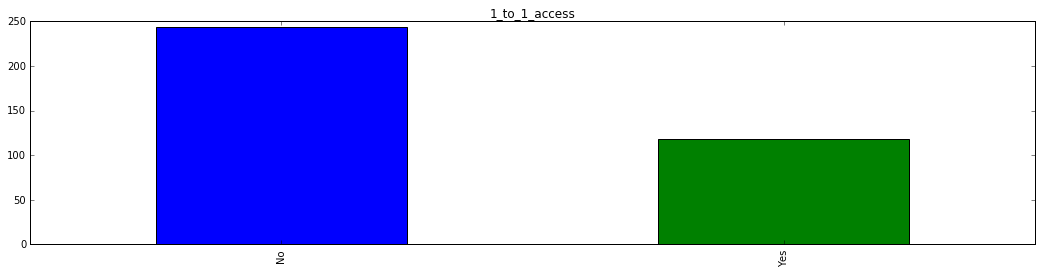

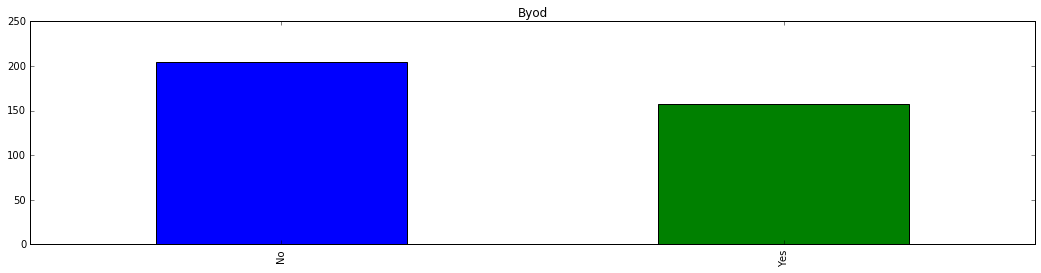

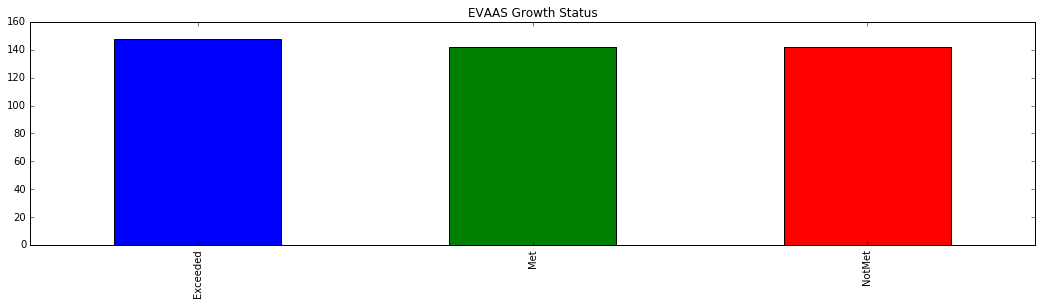

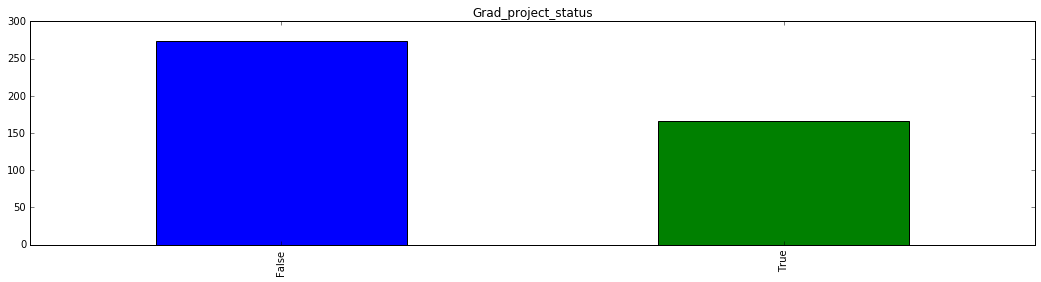

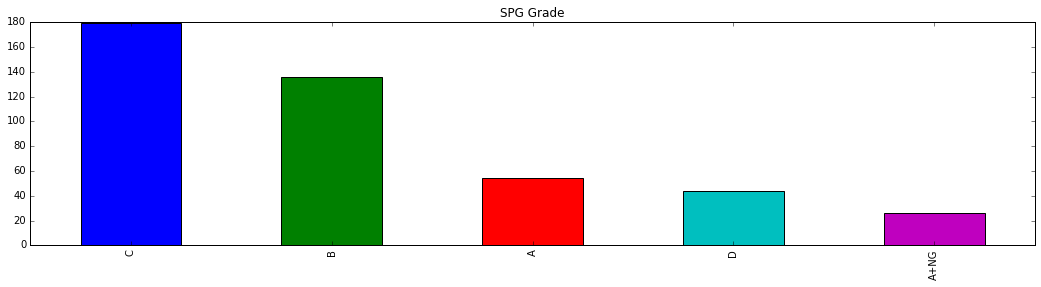

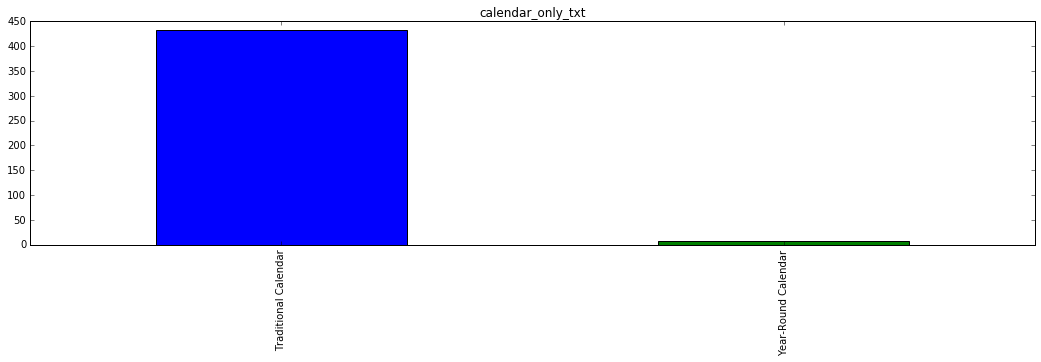

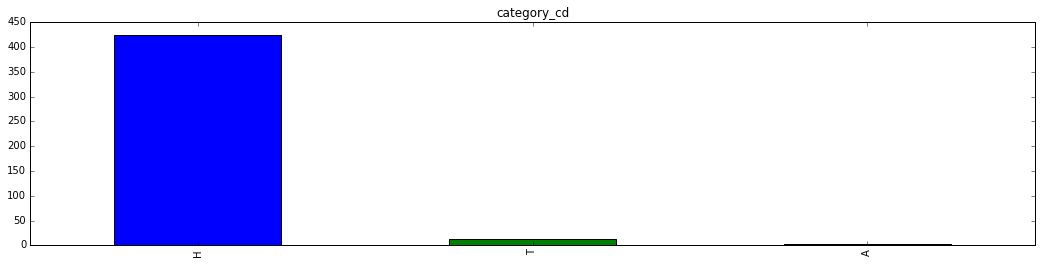

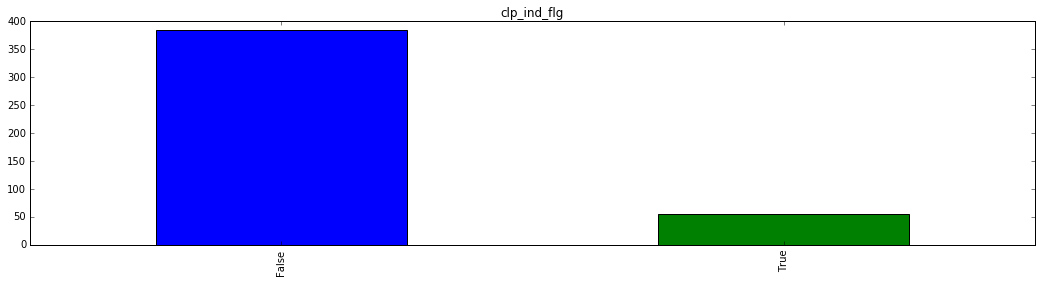

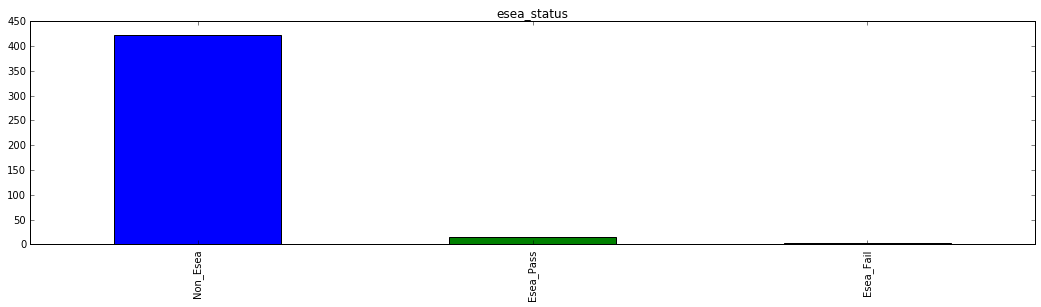

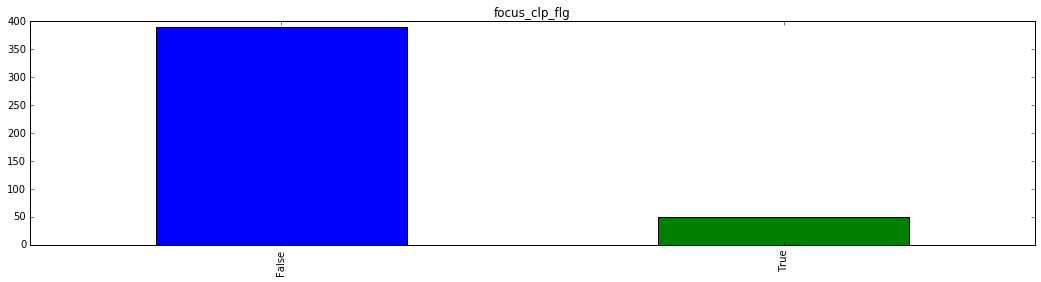

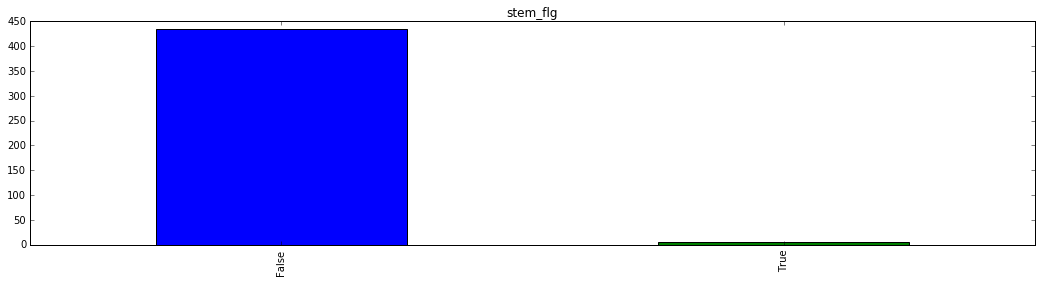

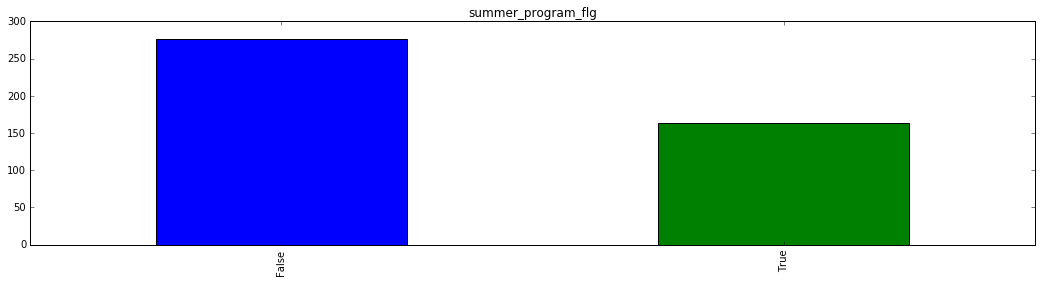

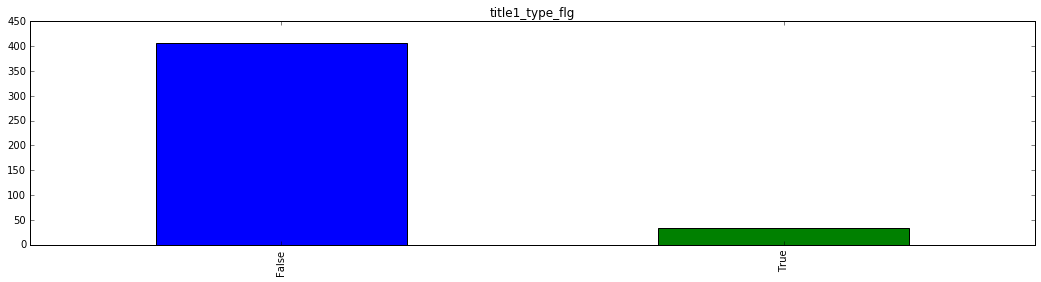

In [15]:
# Examine high schoool categorical variables of interest 
for i in range(0,cat_list_obj_len):
    plt.figure(figsize = (18,4))
    ax = highSchools[cat_list_obj[i]].value_counts().plot(kind='bar')
    plt.title(cat_list_obj[i])
    plt.show()

In [16]:
#Convert Categorical fields to bool using get_dummies
#Use drop_first=true to aviod multicolinierarity
highSchoolsFinal = pd.get_dummies(data=highSchools, 
                       columns=['category_cd', 
                                'calendar_only_txt',
                                'esea_status',
                                'SPG Grade',
                                'EVAAS Growth Status',
                                'Byod',
                                '1_to_1_access'], drop_first=True) #Try drop_first=true to aviod multicolinierarity

highSchoolsFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 116 to 2419
Columns: 134 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(6), float64(115), uint8(13)
memory usage: 406.9 KB


In [17]:
#Replace all NaN with 0
highSchoolsFinal = highSchoolsFinal.fillna(0)

#Check for Missing values again 
missing_values = highSchoolsFinal.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values

,Variable Name,Number Missing Values


In [18]:
highSchoolsFinal.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 116 to 2419
Data columns (total 134 columns):
title1_type_flg                                   bool
clp_ind_flg                                       bool
focus_clp_flg                                     bool
summer_program_flg                                bool
student_num                                       float64
lea_avg_student_num                               float64
Grad_project_status                               bool
stem_flg                                          bool
Avg_Class_Size_Biology                            float64
Avg_Class_Size_EnglishII                          float64
Avg_Class_Size_MathI                              float64
Avg_Dist_Size_Biology                             float64
Avg_Dist_Size_EnglishII                           float64
Avg_Dist_Size_MathI                               float64
lea_total_expense_num                             float64
lea_salary_expense_pct                 

In [19]:
# create x explanatory and y response variable for regression
Y_highSchools = highSchoolsFinal['Graduation_Rate4_Yr'] 
X_highSchools = highSchoolsFinal.drop(['Graduation_Rate4_Yr'], axis=1)

## Review Feature Correlations

Create a correlation heatmap and remove highly correlated features

- https://stackoverflow.com/questions/39409866/correlation-heatmap
- https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
- https://codeyarns.com/2015/04/20/how-to-change-font-size-in-seaborn/

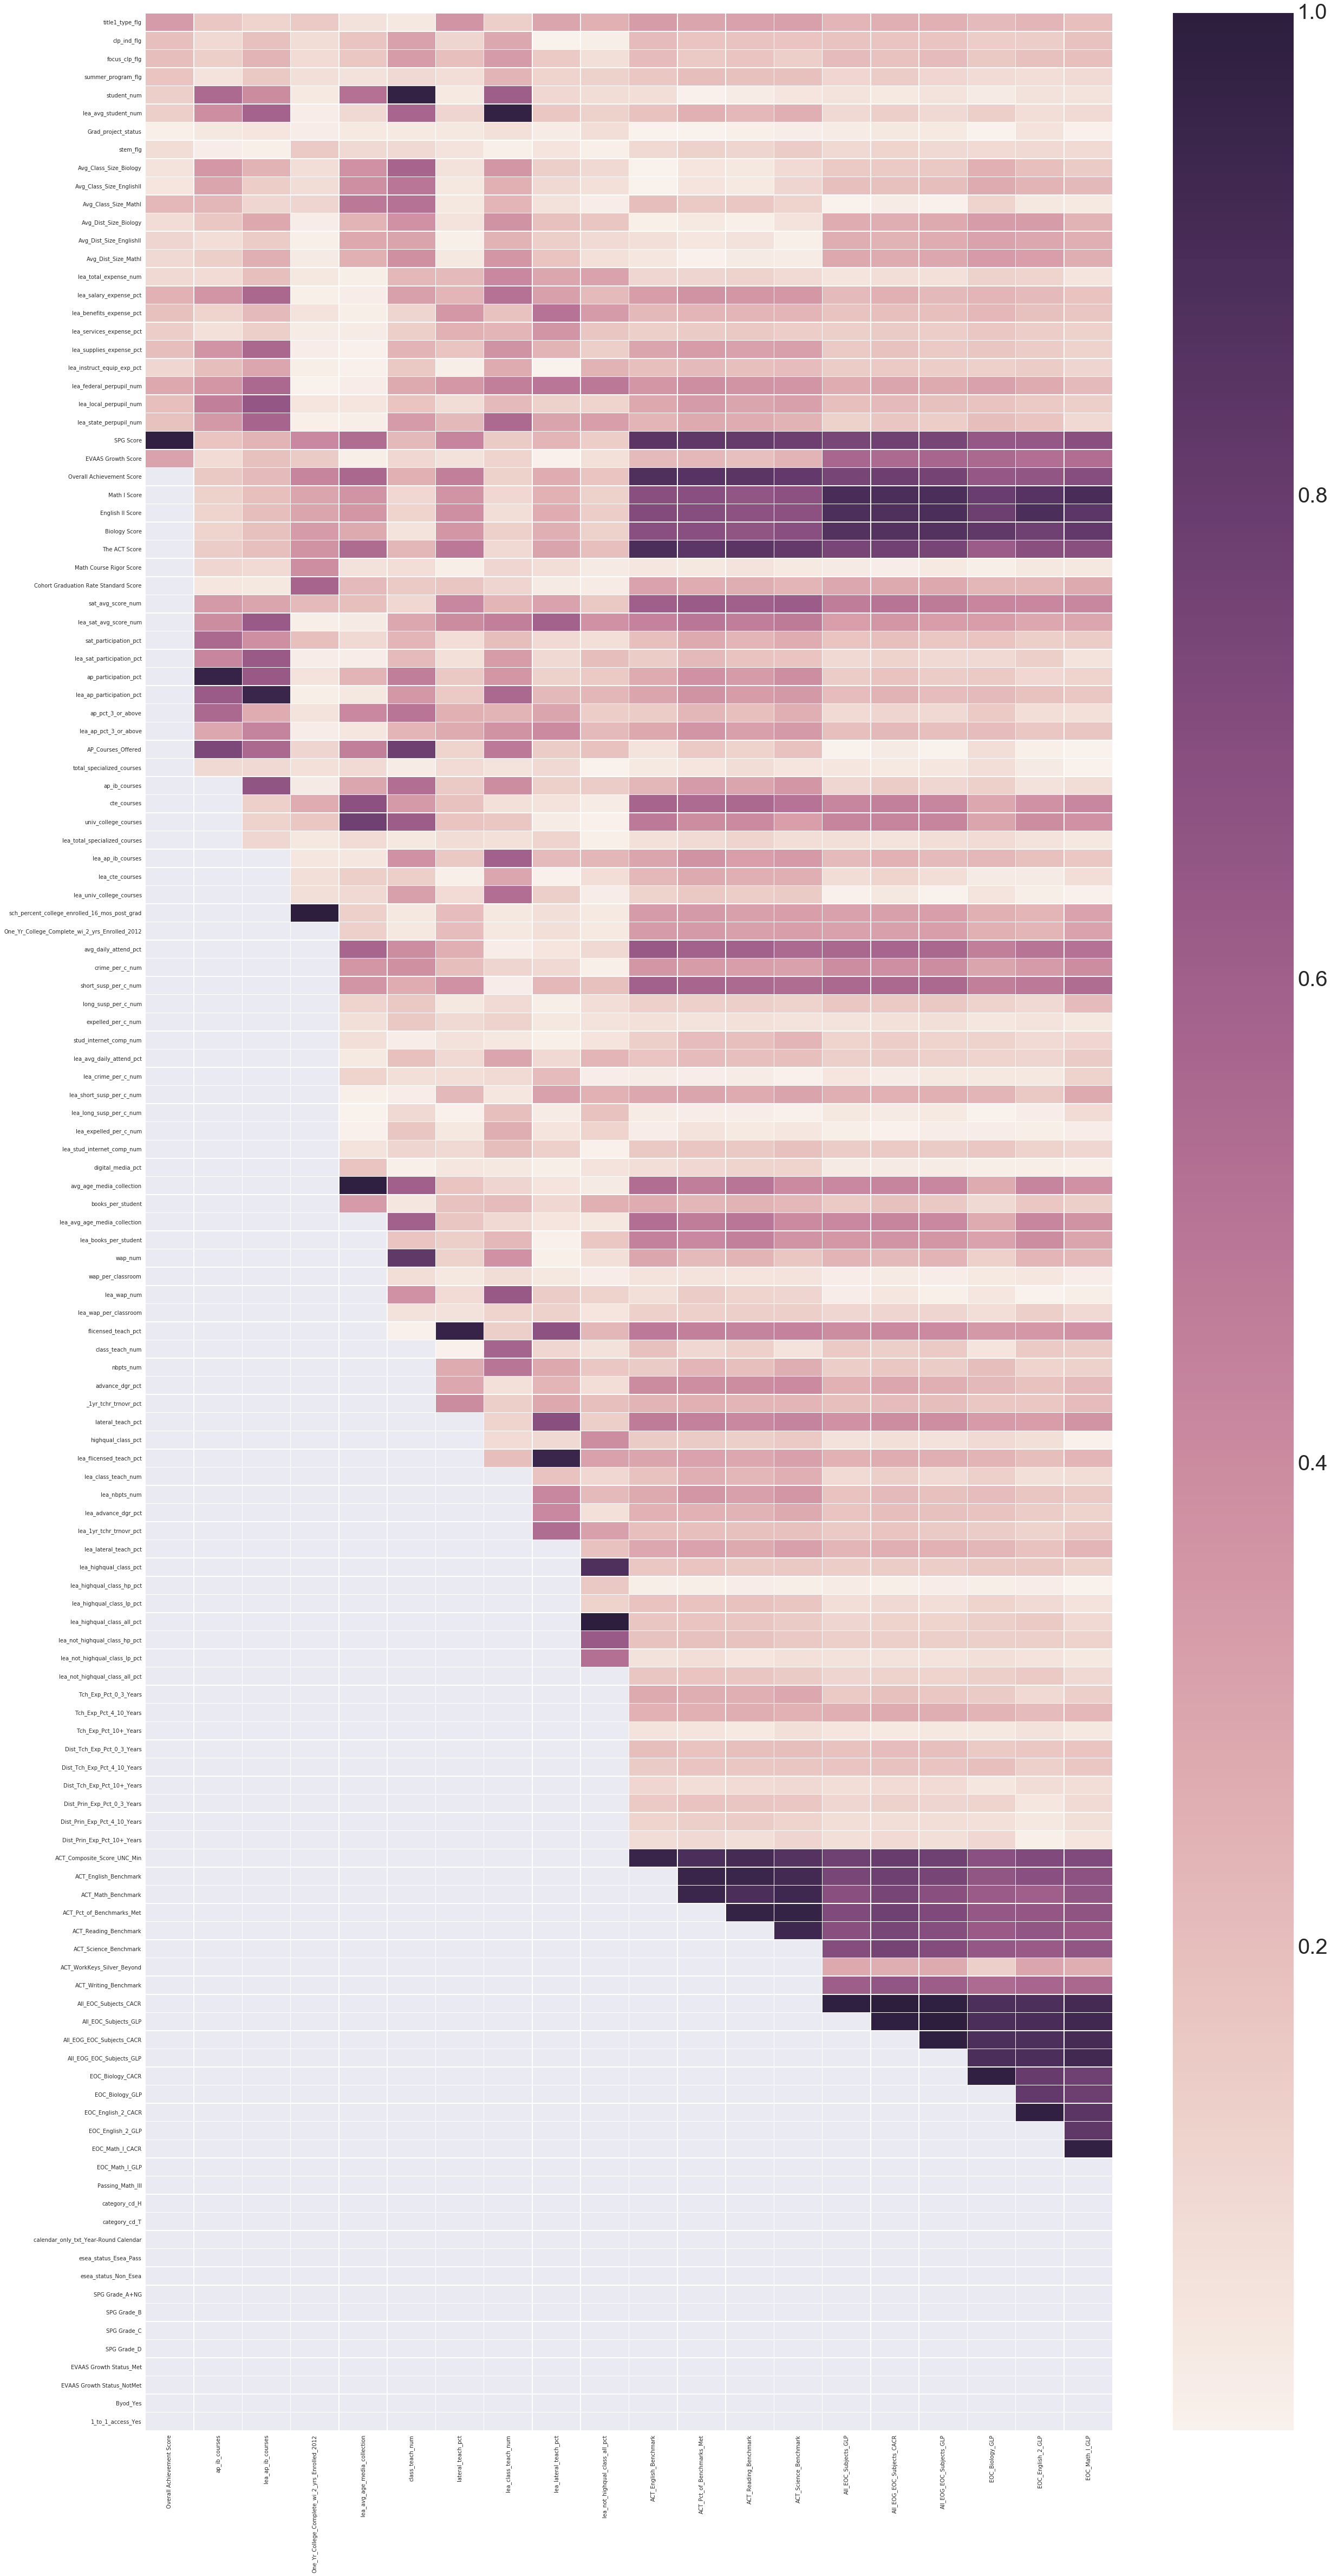

In [20]:
import seaborn as sns
%matplotlib inline

# calculate the correlation matrix
corr_matrix  = X_highSchools.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# plot the heatmap
fig, ax = plt.subplots(figsize=(40,80)) 
sns.set(font_scale=4)
sns.heatmap(upper[to_drop] , linewidths=.5, ax=ax)

In [21]:
#Print a list of the columns with correlations > .95
print("Columns with greater than .95 correlation")
print("*****************************************")
to_drop

Columns with greater than .95 correlation
*****************************************


['Overall Achievement Score',
 'ap_ib_courses',
 'lea_ap_ib_courses',
 'One_Yr_College_Complete_wi_2_yrs_Enrolled_2012',
 'lea_avg_age_media_collection',
 'class_teach_num',
 'lateral_teach_pct',
 'lea_class_teach_num',
 'lea_lateral_teach_pct',
 'lea_not_highqual_class_all_pct',
 'ACT_English_Benchmark',
 'ACT_Pct_of_Benchmarks_Met',
 'ACT_Reading_Benchmark',
 'ACT_Science_Benchmark',
 'All_EOC_Subjects_GLP',
 'All_EOG_EOC_Subjects_CACR',
 'All_EOG_EOC_Subjects_GLP',
 'EOC_Biology_GLP',
 'EOC_English_2_GLP',
 'EOC_Math_I_GLP']

In [22]:
#Restore fontscale back to normal after heatmap
sns.set(font_scale=1)

#Check columns before drop 
X_highSchools.info()

# Drop the highly correlated features from our training data 
X_highSchools = X_highSchools.drop(to_drop, axis=1)

#Check columns after drop 
print('*********************************************')
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 116 to 2419
Columns: 133 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(6), float64(114), uint8(13)
memory usage: 403.5 KB
*********************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 116 to 2419
Columns: 113 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(6), float64(94), uint8(13)
memory usage: 334.7 KB


## Multiple Linear Regression and Cross Validation Using MAE, RMSE, and MAPE

Please see the following link for details on using RMSE vs MAE  to measure accuracy for continuous variables:

-  https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d
-  http://canworksmart.com/using-mean-absolute-error-forecast-accuracy/



In [23]:
#Optimize and Test Multiple Linear Regression to predict graduation rates

#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)                                     
#for train_index, test_index in cv.split(X, y):

#Create linear regression and parameter objects for grid search
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
linreg_clf = GridSearchCV(estimator=linreg
                   , n_jobs=2 # parallel execution
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
linreg_clf.fit(X_highSchools, Y_highSchools)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    1.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [24]:
#Test 4 different model parameter combinations using 10-fold cross validation for a total of 40 models
#Rank the 40 models using the mean test score for each of the 4 different model parameter combinations 
linreg_results = pd.DataFrame(linreg_clf.cv_results_)
linreg_results.sort_values(by="rank_test_score", inplace=True)
headers = ['rank_test_score','mean_test_score','param_fit_intercept','param_normalize'
           ,'std_test_score','std_train_score']  #,'mean_train_score'
linreg_results[headers]

,rank_test_score,mean_test_score,param_fit_intercept,param_normalize,std_test_score,std_train_score
1,1,-4.489938e+00,True,False,5.310488e-01,0.073071
2,2,-1.188257e+01,False,True,2.198958e+01,0.073590
3,2,-1.188257e+01,False,False,2.198958e+01,0.073590
0,4,-5.823387e+10,True,True,1.747016e+11,0.089030


In [25]:
#Print the parameterization of the best estimator
linreg_clf.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
#Create additional scorers and a multi-scorer for use in cross_val_score  
from sklearn.metrics import mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual <> 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean()

#Create scorers for rmse and mape functions
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer to return multiple mean error scores (need latest version of scikit!)
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
#https://github.com/scikit-learn/scikit-learn/pull/7388
#https://github.com/drorata/multiscorer

errorScoring = {'MAE':  make_scorer(score_func=mean_absolute_error, greater_is_better=False), 
                'RMSE': make_scorer(score_func=rmse, greater_is_better=False),
                'MAPE': make_scorer(score_func=mape, greater_is_better=False)
               } 

In [27]:
#10-fold cross-validation using the parameters for the top performing model and MAE, MAPE, and RMSE

#Create regression object using parameters for the top performing model
top_linreg_clf = linreg_clf.best_estimator_  #LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

from sklearn.model_selection import cross_validate
scores = cross_validate(top_linreg_clf, X_highSchools, Y_highSchools, scoring=errorScoring, cv=cv, return_train_score=True)


#cross val score sign-flips the outputs of MAE
# https://github.com/scikit-learn/scikit-learn/issues/2439
scores['test_MAE'] = scores['test_MAE'] * -1
scores['test_MAPE'] = scores['test_MAPE'] * -1
scores['test_RMSE'] = scores['test_RMSE'] * -1

#print mean MAE for all folds 
maeAvg = scores['test_MAE'].mean()
print_str = "The average MAE for all ten folds is {maeAvg}."
print(print_str.format(maeAvg=maeAvg))

#print mean test_MAPE for all folds
scores['test_MAPE'] = scores['test_MAPE']
mape_avg = scores['test_MAPE'].mean()
print_str = "The average MAE percentage (MAPE) for all ten folds is {mape_avg:.2%}"
print(print_str.format(mape_avg=mape_avg))

#print mean MAE for all folds 
RMSEavg = scores['test_RMSE'].mean()
print_str = "The average RMSE for all ten folds is {RMSEavg}."
print(print_str.format(RMSEavg=RMSEavg))
print('*********************************************************')

print('Cross Validation Fold Mean Error Scores')
scoresResults = pd.DataFrame()
scoresResults['MAE'] = scores['test_MAE']
scoresResults['MAPE'] = scores['test_MAPE']
scoresResults['RMSE'] = scores['test_RMSE']
scoresResults

The average MAE for all ten folds is 4.48993787943.
The average MAE percentage (MAPE) for all ten folds is 5.06%
The average RMSE for all ten folds is 6.21934997054.
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,4.529259,0.052232,6.257981
1,4.095183,0.047887,5.414602
2,4.191614,0.047593,5.883055
3,5.040630,0.056509,6.992213
4,3.920419,0.045243,5.403575
5,5.674442,0.060518,9.171103
6,4.956487,0.054045,6.968130
7,4.099403,0.045766,5.260623
8,4.201992,0.048931,5.682267
9,4.189951,0.047765,5.159951


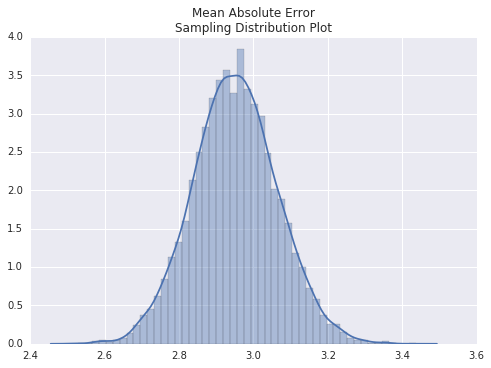

The mean of the distribution is 2.95101979887
The median of the distribution is 2.95012401315


In [28]:
#Build a sampling distribution of the MAE via bootstrap
# - 10000 random samples with replacement from all 440 NC High Schools 
# - Look at dist plot for the 10,000 MAE's from 440 predictions per set 
from sklearn.utils import resample
import seaborn as sns

# train on all of the data
top_linreg_clf.fit(X_highSchools, Y_highSchools)

maeList = []  # an empty list for MAE
sampleCt = len(Y_highSchools) # large same equal to validation set size, but w/ replacement!
y_hatMin = 0
y_hatMax = 0

for i in xrange(10000): # 10,000 samples
    X_samp, y = resample(X_highSchools, Y_highSchools, replace=True, n_samples=sampleCt)
    y_hat = top_linreg_clf.predict(X_samp)
    mae = mean_absolute_error(y, y_hat)
    maeList.append(mae)
    y_hatMin = np.minimum(y_hat.min(), y_hatMin)
    y_hatMax = np.maximum(y_hat.max(), y_hatMax)

#Print distributions for MAE
sns.distplot(maeList).set_title("Mean Absolute Error\nSampling Distribution Plot")  
plt.show()

print("The mean of the distribution is {mean}".format(mean=np.mean(maeList)))
print("The median of the distribution is {median}".format(median=np.median(maeList)))

There were 4400000 total samples taken.
The minimum sampled prediction is 0.0
The maximum sampled prediction is 104.992230274


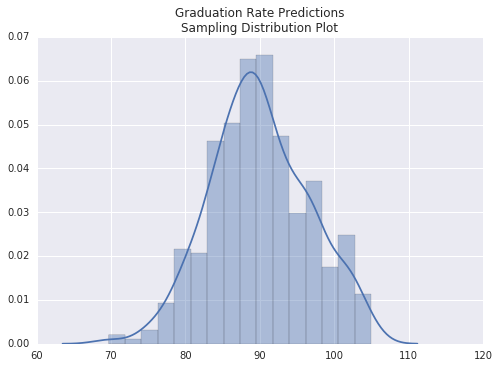

The mean of the distribution is 89.9963142398
The median of the distribution is 89.6179072624


,count,mean,std,min,25%,50%,75%,max
Predicted 4 Year Graduation Rates,440.0,89.996314,6.585163,69.688594,85.813858,89.617907,94.72523,104.99223


In [29]:
#Inspect a bootstrapped random sample of our last random set of 440 predcitions 
print("There were {n} total samples taken.".format(n=10000 * 440))
print("The minimum sampled prediction is {m}".format(m=y_hatMin))
print("The maximum sampled prediction is {m}".format(m=y_hatMax))

#Print distributions for the last sampled set of 440 predictions
sns.distplot(y_hat).set_title("Graduation Rate Predictions\nSampling Distribution Plot")  
plt.show()

print("The mean of the distribution is {mean}".format(mean=np.mean(y_hat)))
print("The median of the distribution is {median}".format(median=np.median(y_hat)))

yhats = pd.DataFrame({"Predicted 4 Year Graduation Rates":y_hat})
yhats.describe().T

In [30]:
#Examine our original response variable Y
grRate4yr = pd.DataFrame({"Actual 4 Year Graduation Rates":Y_highSchools})
grRate4yr.describe().T

,count,mean,std,min,25%,50%,75%,max
Actual 4 Year Graduation Rates,440.0,90.132727,7.680643,60.0,84.8,90.2,100.0,100.0


In [31]:
#Examine our sampled MAE predictions
linreg_mae = pd.DataFrame({"sample_mae":maeList})
linreg_mae.describe().T

,count,mean,std,min,25%,50%,75%,max
sample_mae,10000.0,2.95102,0.113238,2.510812,2.875847,2.950124,3.024933,3.437692


In [32]:
#look at the 95% confidence interval for our samples
x_bar = round(linreg_mae.describe().T['mean'].values[0],2)
fifth = round(np.percentile(maeList, 5),2)
ninety_fifth = round(np.percentile(maeList, 95),2)


print("The 95% confidence interval for the mean {mean} is {low} to {high}.".format(mean=x_bar, low=fifth, high=ninety_fifth))

The 95% confidence interval for the mean 2.95 is 2.76 to 3.14.


### Multiple Linear Regression Predictions 

Multiple Linear Regression predicts the 4 year graduation rate of North Carolina Public Schools within +- 4.48 percentage points accuracy when considering the Mean Absolute Error rate.  Using MAE, this model is 95.52% accurate.  The average Mean Absolute Error Percentage (MAPE) during ten fold cross validation is 5.06%.  Using MAPE, this model is 94.94% accurate. The average Root Mean Squared Error during ten fold cross validation is 6.21%. Using RMSE, this model is 93.79% accurate.  Since Root Mean Squared Error penalizes large errors more heavily than smaller errors, a difference of only 1.73% between the average MAE and RMSE for this model indicates that when predictions are wrong, the errors are consistent and smaller in value.             

A bootstrap of of 4,400,000 samples including 10,000 sets of 440 predictions using this model produces a minimum predicted value of 0 and a maximum predicted value of 104.99%.  The average Mean Absolute Error across the 10,000 bootstraps is 2.95 with a 95% confidence interval of 2.77 to 3.14.    

Since our Multiple Linear Regression is making graduation rate predictions above 100%, we can produce a more accurate model by simply clipping the model's predictions between 0% and 100% to match the range of our response variable.  Likewise, it would also be possible to use Logistic Regression to produce a response variable which is capped between 0 and 100 percent.   

## Multiple Linear Regression Capped between 0 and 100

High school graduation rates are a percentage value between 0 and 100. Linear regression may predict response values less than 0 and greater than 100 percent.  In the following example, I "roll my own estimator" to clip Linear Regression graduation rate predictions between 0 and 100.  This improves average Mean Absolute Error from +- 4.48 in the previous example to +- 4.22 percentage points.    

In the alternative, **Logistic Regression** could be used to limit the range of response variables as well.  

-  http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator
-  https://github.com/scikit-learn/scikit-learn/issues/6950
-  http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
-  https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py

In [33]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(BaseEstimator, RegressorMixin):

    def __init__(self,regObj=LinearRegression()):
        self.regObj = regObj

    def fit(self, X, y):
        return self.regObj.fit(X, y)

    def predict(self, X):
        return np.clip(self.regObj.predict(X), 0, 100) 

In [34]:
#10-fold cross-validation using the parameters for the top performing model 
#CAP predictions between 0 and 100% 
#Evaluate cross-validation results using MAE, MAPE, and RMSE

#CappedLinearRegression predictions between 0 and 100% 
capped_linreg_clf = CappedLinearRegression(regObj=linreg_clf.best_estimator_) 

scores = cross_validate(capped_linreg_clf, X_highSchools, Y_highSchools, scoring=errorScoring, cv=cv, return_train_score=True)

#cross val score sign-flips the outputs of MAE
# https://github.com/scikit-learn/scikit-learn/issues/2439
scores['test_MAE'] = scores['test_MAE'] * -1
scores['test_MAPE'] = scores['test_MAPE'] * -1
scores['test_RMSE'] = scores['test_RMSE'] * -1

#print mean MAE for all folds 
maeAvg = scores['test_MAE'].mean()
print_str = "The average MAE for all ten folds is {maeAvg}."
print(print_str.format(maeAvg=maeAvg))

#print mean test_MAPE for all folds
scores['test_MAPE'] = scores['test_MAPE']
mape_avg = scores['test_MAPE'].mean()
print_str = "The average MAE percentage (MAPE) for all ten folds is {mape_avg:.2%}"
print(print_str.format(mape_avg=mape_avg))

#print mean MAE for all folds 
RMSEavg = scores['test_RMSE'].mean()
print_str = "The average RMSE for all ten folds is {RMSEavg}."
print(print_str.format(RMSEavg=RMSEavg))
print('*********************************************************')

print('Cross Validation Fold Mean Error Scores')
scoresResults = pd.DataFrame()
scoresResults['MAE'] = scores['test_MAE']
scoresResults['MAPE'] = scores['test_MAPE']
scoresResults['RMSE'] = scores['test_RMSE']
scoresResults

The average MAE for all ten folds is 4.22395480033.
The average MAE percentage (MAPE) for all ten folds is 4.80%
The average RMSE for all ten folds is 6.01240607657.
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,4.515048,0.052090,6.257623
1,4.038629,0.047290,5.355696
2,3.465531,0.040255,4.878145
3,4.661760,0.052720,6.813717
4,3.874945,0.044735,5.306766
5,5.126369,0.055037,9.014042
6,4.392097,0.048401,6.509764
7,3.909198,0.043864,5.166102
8,4.140962,0.048320,5.674565
9,4.115009,0.047016,5.147639


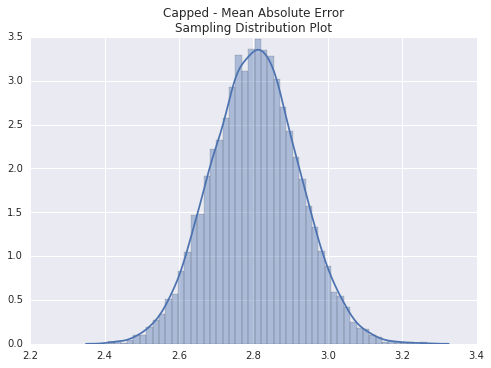

The mean of the distribution is 2.80462615748
The median of the distribution is 2.80532609269


In [35]:
# train on all of the data
capped_linreg_clf.fit(X_highSchools, Y_highSchools)

maeList = []  # an empty list for MAE
sampleCt = len(Y_highSchools) # large same equal to validation set size, but w/ replacement!
y_hatMin = 0
y_hatMax = 0

for i in xrange(10000): # 10,000 samples
    X_samp, y = resample(X_highSchools, Y_highSchools, replace=True, n_samples=sampleCt)
    y_hat = capped_linreg_clf.predict(X_samp)
    mae = mean_absolute_error(y, y_hat)
    maeList.append(mae)
    y_hatMin = np.minimum(y_hat.min(), y_hatMin)
    y_hatMax = np.maximum(y_hat.max(), y_hatMax)

#Print distributions for MAE
sns.distplot(maeList).set_title("Capped - Mean Absolute Error\nSampling Distribution Plot")  
plt.show()

print("The mean of the distribution is {mean}".format(mean=np.mean(maeList)))
print("The median of the distribution is {median}".format(median=np.median(maeList)))

There were 4400000 total samples taken.
The minimum sampled prediction is 0.0
The maximum sampled prediction is 100.0


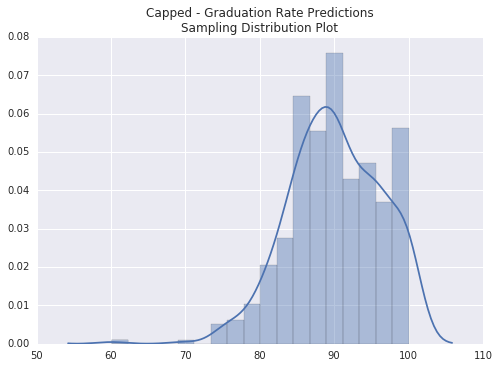

The mean of the distribution is 90.0786751274
The median of the distribution is 89.9235533654


,count,mean,std,min,25%,50%,75%,max
Predicted 4 Year Graduation Rates CAPPED,440.0,90.078675,6.22124,60.084192,86.009207,89.923553,94.904763,100.0


In [36]:
#Inspect a bootstrapped random sample of our last random set of 440 predcitions 
print("There were {n} total samples taken.".format(n=10000 * 440))
print("The minimum sampled prediction is {m}".format(m=y_hatMin))
print("The maximum sampled prediction is {m}".format(m=y_hatMax))

#Print distributions for the last sampled set of 440 predictions
sns.distplot(y_hat).set_title("Capped - Graduation Rate Predictions\nSampling Distribution Plot")  
plt.show()

print("The mean of the distribution is {mean}".format(mean=np.mean(y_hat)))
print("The median of the distribution is {median}".format(median=np.median(y_hat)))

yhats = pd.DataFrame({"Predicted 4 Year Graduation Rates CAPPED":y_hat})
yhats.describe().T

In [37]:
#Examine our sampled MAE predictions
linreg_mae = pd.DataFrame({"sample_mae":maeList})
linreg_mae.describe().T

,count,mean,std,min,25%,50%,75%,max
sample_mae,10000.0,2.804626,0.117968,2.408881,2.72534,2.805326,2.882969,3.266028


In [38]:
#look at the 95% confidence interval for our samples
x_bar = round(linreg_mae.describe().T['mean'].values[0],2)
fifth = round(np.percentile(maeList, 5),2)
ninety_fifth = round(np.percentile(maeList, 95),2)


print("The 95% CAPPED confidence interval for the mean {mean} is {low} to {high}.".format(mean=x_bar, low=fifth, high=ninety_fifth))

The 95% CAPPED confidence interval for the mean 2.8 is 2.61 to 3.0.


### Capped Multiple Linear Regression Predictions 

Capped Multiple Linear Regression improves predictions of the 4 year graduation rate for North Carolina Public Schools from within +-4.48 to +-4.22 percentage points when considering the Mean Absolute Error rate.  When considering MAE, this model is 95.78% accurate.  The model's accuracy increases from 95.52% to 95.78% using predictions clipped between 0 and 100% to mirror the response variable's actual range.  The average Mean Absolute Error Percentage (MAPE) during ten fold cross validation improves from 5.06% to 4.80%.  Using MAPE, this model is 95.20% accurate. The average Root Mean Squared Error during ten fold cross validation improves from 6.21% to 6.01%. Using RMSE, this model is 93.99% accurate.  The difference between average MAE and RMSE during ten fold cross validation changes from 1.73% to 1.79%.  A difference of only 1.79% between the average MAE and RMSE for this model indicates that when predictions are wrong, the errors are consistent and smaller in value.              

A bootstrap of 4,400,000 samples including 10,000 sets of 440 predictions using this model produces a minimum predicted value of 0 and a maximum predicted value of 100%.  The average Mean Absolute Error across the 10,000 bootstraps is 2.81 with a 95% confidence interval of 2.62 to 3.00.    

## Multiple Linear Regression Feature Importance

In [39]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_highSchools_scl = scaler.transform(X_highSchools)

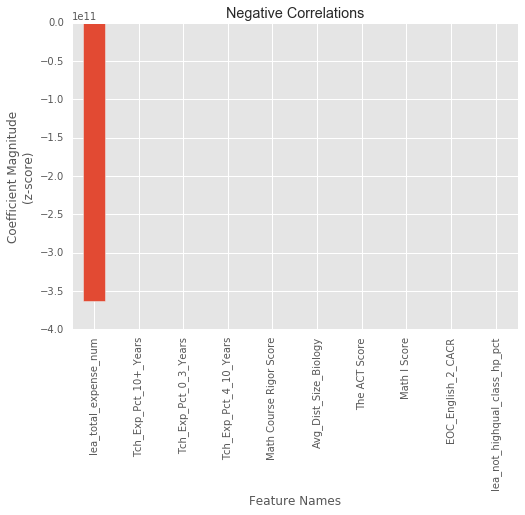

In [40]:
#Now train our capped linear regression model on all the scaled training data
#We use the best linear regression model parameters found by our grid search
linreg_fi = linreg_clf.best_estimator_

#Fit the model using all of our scaled data
linreg_fi.fit(X_highSchools_scl, Y_highSchools)

#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = linreg_fi.coef_
feature_names = X_highSchools.columns
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='weights', inplace=True)

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(10)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar')

ax.set_title("Negative Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

In [41]:
#Show the negative coefficient values
wt_plt_df

,absolute_weights,feature_names,weights
14,3.630731e+11,lea_total_expense_num,-3.630731e+11
84,2.505895e+01,Tch_Exp_Pct_10+_Years,-2.505895e+01
82,2.258174e+01,Tch_Exp_Pct_0_3_Years,-2.258174e+01
83,1.801629e+01,Tch_Exp_Pct_4_10_Years,-1.801629e+01
29,2.346520e+00,Math Course Rigor Score,-2.346520e+00
11,1.440901e+00,Avg_Dist_Size_Biology,-1.440901e+00
28,1.156219e+00,The ACT Score,-1.156219e+00
25,1.140261e+00,Math I Score,-1.140261e+00
97,1.049652e+00,EOC_English_2_CACR,-1.049652e+00
80,1.010843e+00,lea_not_highqual_class_hp_pct,-1.010843e+00


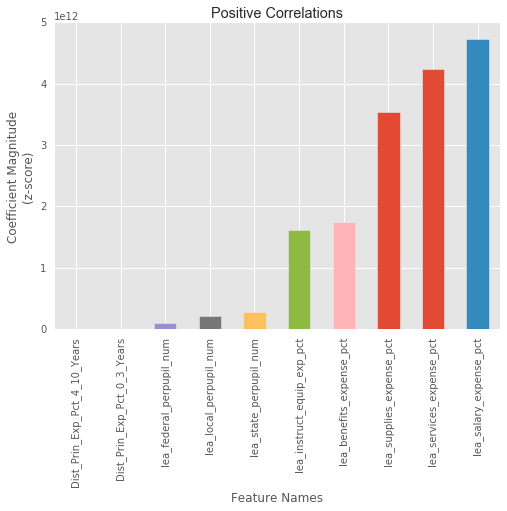

In [42]:
#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.tail(10)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar')

ax.set_title("Positive Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

In [43]:
#Show the positive coefficient values
wt_plt_df

,absolute_weights,feature_names,weights
89,1.725534e+02,Dist_Prin_Exp_Pct_4_10_Years,1.725534e+02
88,1.934762e+02,Dist_Prin_Exp_Pct_0_3_Years,1.934762e+02
20,1.018558e+11,lea_federal_perpupil_num,1.018558e+11
21,2.186617e+11,lea_local_perpupil_num,2.186617e+11
22,2.729927e+11,lea_state_perpupil_num,2.729927e+11
19,1.615631e+12,lea_instruct_equip_exp_pct,1.615631e+12
16,1.749144e+12,lea_benefits_expense_pct,1.749144e+12
18,3.532849e+12,lea_supplies_expense_pct,3.532849e+12
17,4.233925e+12,lea_services_expense_pct,4.233925e+12
15,4.725933e+12,lea_salary_expense_pct,4.725933e+12


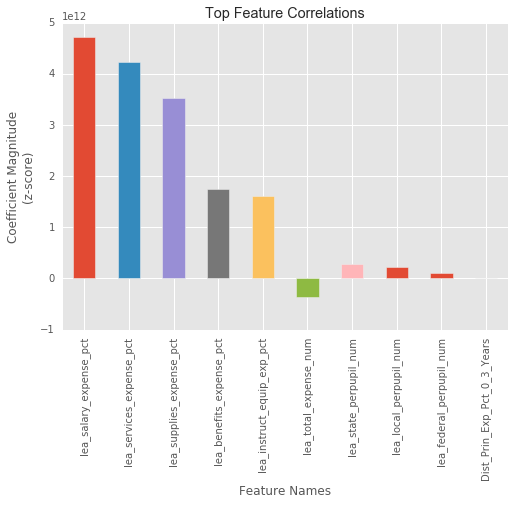

In [44]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = linreg_fi.coef_
feature_names = X_highSchools.columns
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(10)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar')

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

In [45]:
wt_plt_df

,absolute_weights,feature_names,weights
15,4.725933e+12,lea_salary_expense_pct,4.725933e+12
17,4.233925e+12,lea_services_expense_pct,4.233925e+12
18,3.532849e+12,lea_supplies_expense_pct,3.532849e+12
16,1.749144e+12,lea_benefits_expense_pct,1.749144e+12
19,1.615631e+12,lea_instruct_equip_exp_pct,1.615631e+12
14,3.630731e+11,lea_total_expense_num,-3.630731e+11
22,2.729927e+11,lea_state_perpupil_num,2.729927e+11
21,2.186617e+11,lea_local_perpupil_num,2.186617e+11
20,1.018558e+11,lea_federal_perpupil_num,1.018558e+11
88,1.934762e+02,Dist_Prin_Exp_Pct_0_3_Years,1.934762e+02


In [46]:
import sklearn
print(sklearn.__version__)

0.19.1
